In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [54]:
!ls /kaggle/input/titanic/

gender_submission.csv  test.csv  train.csv


In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_auc_score, recall_score, precision_score

In [56]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
test = pd.read_csv("/kaggle/input/titanic/test.csv")
submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
train_orig = train.copy()
test_orig = test.copy()
submission_orig = submission.copy()

In [57]:
train.shape, test.shape, train.index, test.index

((891, 12),
 (418, 11),
 RangeIndex(start=0, stop=891, step=1),
 RangeIndex(start=0, stop=418, step=1))

In [58]:
train.columns.difference(test.columns), train.columns.intersection(submission.columns)

(Index(['Survived'], dtype='object'),
 Index(['PassengerId', 'Survived'], dtype='object'))

In [59]:
train.duplicated().sum(), test.duplicated().sum()
# there are no duplicate rows in both train n test

(0, 0)

In [60]:
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train,test])
data_orig = data.copy()
data.head()

PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   
3            4       1.0       1   
4            5       0.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked source  
0      0         A/5 21171   7.2500   NaN        S  train  
1      0          PC 17599  71.2833   C85        C  train  
2      0  STON/O2. 3101282   7.9250   NaN        S  train  
3      0            113803  53.1000  C123        S  train  
4      0            373450   8.0500   NaN        S  train

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  source       1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [62]:
submission.shape, submission.index, submission.duplicated().sum(), submission.head()

((418, 2),
 RangeIndex(start=0, stop=418, step=1),
 0,
    PassengerId  Survived
 0          892         0
 1          893         1
 2          894         0
 3          895         0
 4          896         1)

In [63]:
submission['Survived'].value_counts(),submission.isna().sum()

(0    266
 1    152
 Name: Survived, dtype: int64,
 PassengerId    0
 Survived       0
 dtype: int64)

In [64]:
#submission.to_csv("asis_submission.csv")
# sumitting asis = 0.76555
#0    266
#1    152

In [65]:
data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
source            0
dtype: int64

In [66]:
display(data[data['source']=="train"].isna().sum())
display(data.drop(columns='Survived').isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
source           0
dtype: int64

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
source            0
dtype: int64

In [67]:
''' not working 
data[data.drop(columns='Survived').isna()]
data.isna()
'''

" not working \ndata[data.drop(columns='Survived').isna()]\ndata.isna()\n"

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  source       1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


In [69]:
train.shape, test.shape, data.shape, data.index

((891, 13),
 (418, 12),
 (1309, 13),
 Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
             ...
             408, 409, 410, 411, 412, 413, 414, 415, 416, 417],
            dtype='int64', length=1309))

In [70]:
data = data.reset_index().drop(columns=['index'])#,'level_0'])
data.index


RangeIndex(start=0, stop=1309, step=1)

In [71]:
data

PassengerId  Survived  Pclass  \
0               1       0.0       3   
1               2       1.0       1   
2               3       1.0       3   
3               4       1.0       1   
4               5       0.0       3   
...           ...       ...     ...   
1304         1305       NaN       3   
1305         1306       NaN       1   
1306         1307       NaN       3   
1307         1308       NaN       3   
1308         1309       NaN       3   

                                                   Name     Sex   Age  SibSp  \
0                               Braund, Mr. Owen Harris    male  22.0      1   
1     Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                                Heikkinen, Miss. Laina  female  26.0      0   
3          Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                              Allen, Mr. William Henry    male  35.0      0   
...                                                 ...     ...   ...    ...   
1304                                 Spector, Mr. Woolf    male   NaN      0   
1305                       Oliva y Ocana, Dona. Fermina  female  39.0      0   
1306                       Saether, Mr. Simon Sivertsen    male  38.5      0   
1307                                Ware, Mr. Frederick    male   NaN      0   
1308                           Peter, Master. Michael J    male   NaN      1   

      Parch              Ticket      Fare Cabin Embarked source  
0         0           A/5 21171    7.2500   NaN        S  train  
1         0            PC 17599   71.2833   C85        C  train  
2         0    STON/O2. 3101282    7.9250   NaN        S  train  
3         0              113803   53.1000  C123        S  train  
4         0              373450    8.0500   NaN        S  train  
...     ...                 ...       ...   ...      ...    ...  
1304      0           A.5. 3236    8.0500   NaN        S   test  
1305      0            PC 17758  108.9000  C105        C   test  
1306      0  SOTON/O.Q. 3101262    7.2500   NaN        S   test  
1307      0              359309    8.0500   NaN        S   test  
1308      1                2668   22.3583   NaN        C   test  

[1309 rows x 13 columns]

In [72]:
data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
source            2
dtype: int64

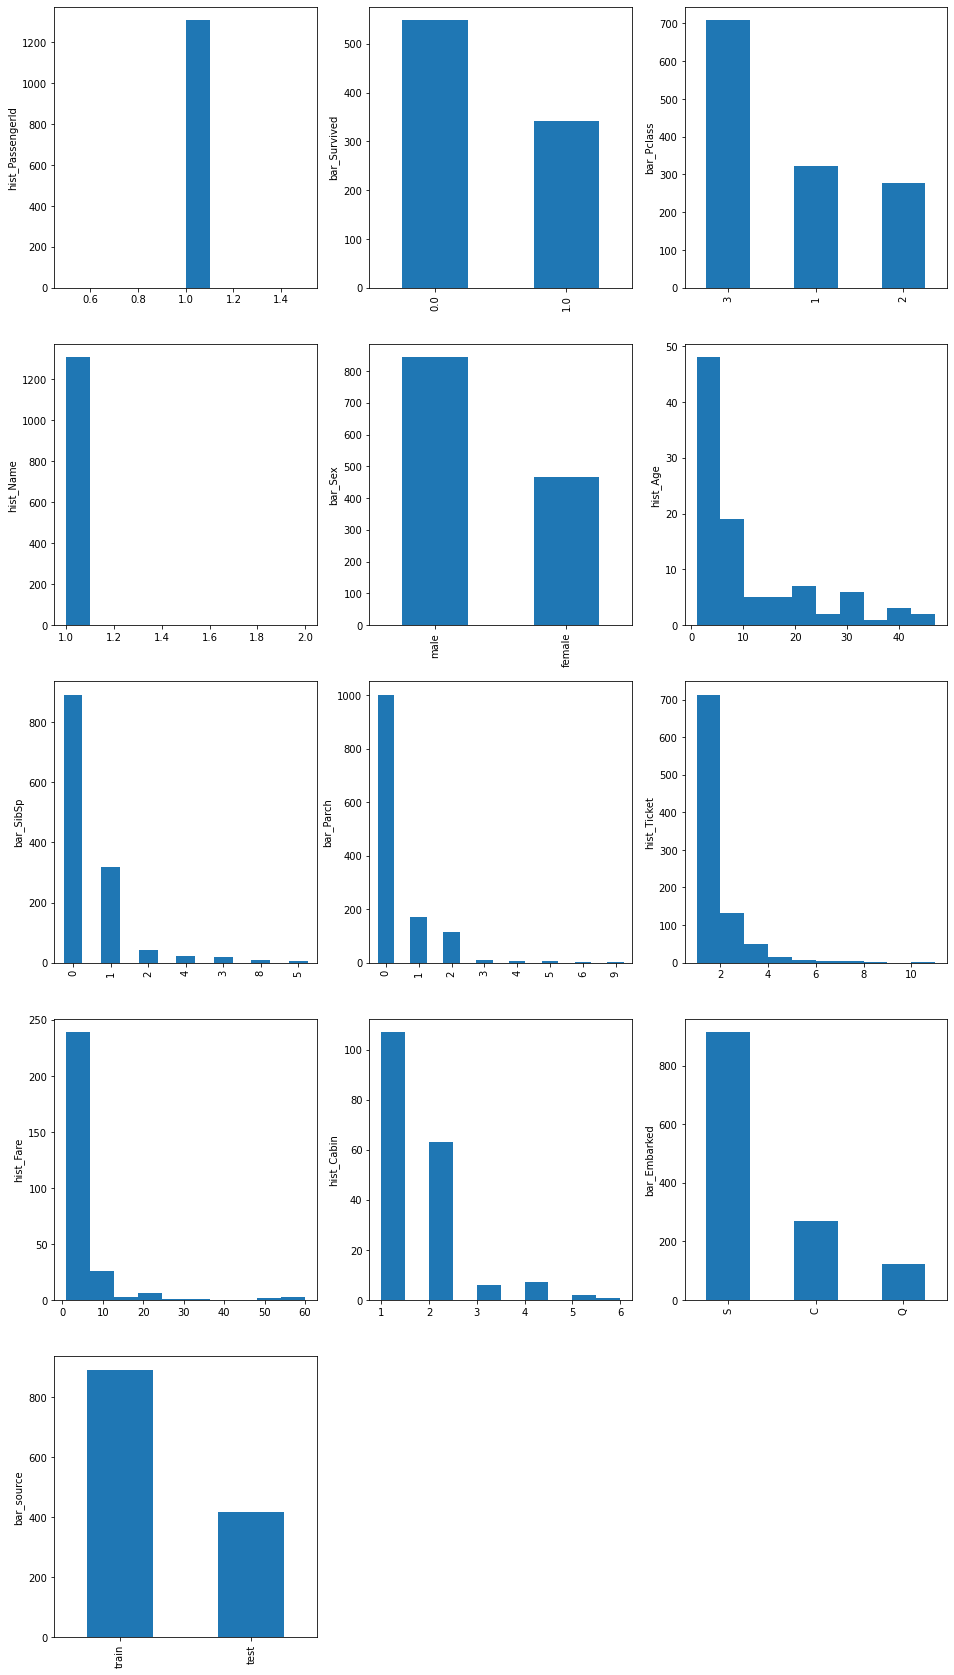

In [73]:
%matplotlib inline
plt.figure(figsize=(16,30))
k=1
col_cnt = 3
row_cnt = int(np.ceil(len(data.columns)/3))
for col in data.columns:
    plt.subplot(row_cnt,col_cnt,k)
    if data[col].nunique()<25: 
        title='bar'
        data[col].value_counts().plot(kind ='bar')
    else: 
        title='hist'
        data[col].value_counts().plot(kind ='hist')
    #plt.title(title+'_'+col)
    plt.ylabel(title+'_'+col)    
    k+=1
plt.show()

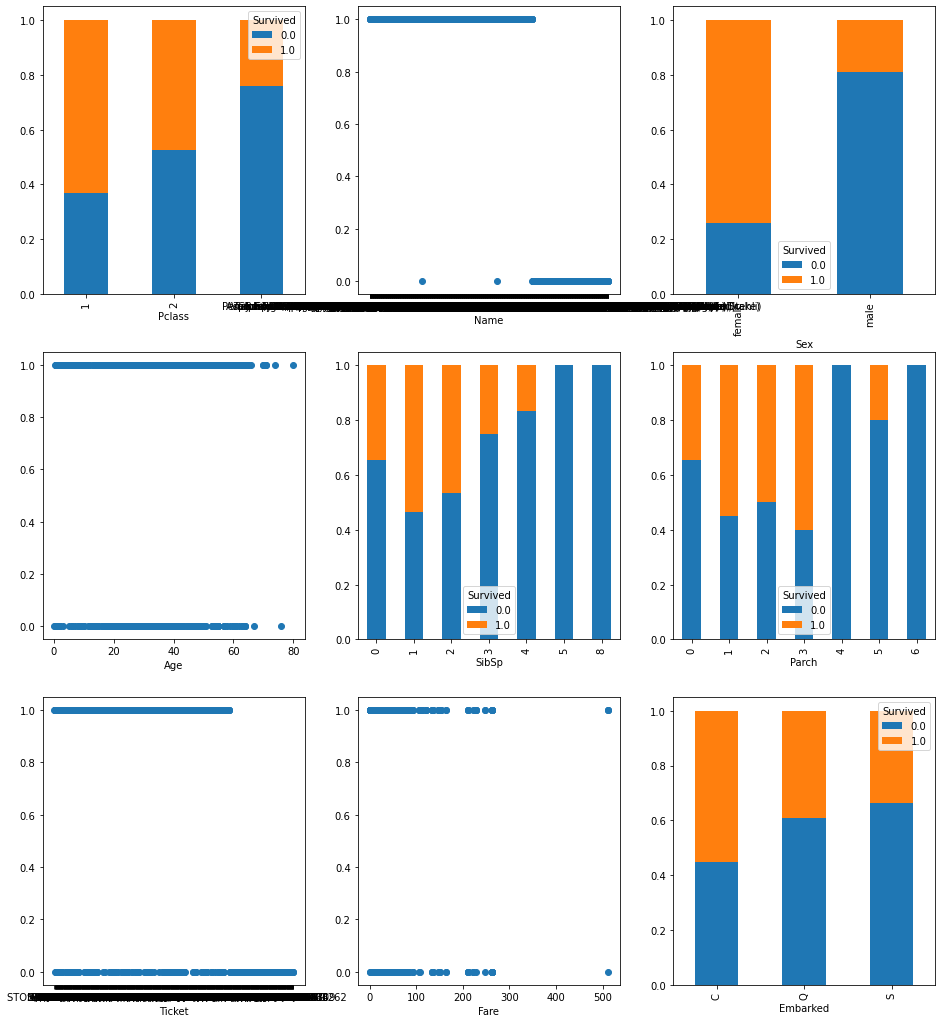

In [74]:
%matplotlib inline
j=k=0
col_cnt = 3
j=[idx for idx, col in enumerate(data.drop(columns=['PassengerId','Survived','source','Cabin']).columns) if(data[col].nunique()<25) ]
j=len(j)
row_cnt = int(np.ceil(j/3))
row_cnt+=1

fig, ax = plt.subplots(ncols=col_cnt, nrows=row_cnt, figsize=(16, row_cnt*6))
ax = ax.flatten()
tgt_var = train.columns.difference(test.columns).values[0]

for idx, col in enumerate(data.drop(columns=['PassengerId','Survived','source','Cabin']).columns) : 
    if data[col].nunique()<25 : 
        cross = pd.crosstab(data[col],data[tgt_var])      
        cross.div(cross.sum(1), axis=0).plot(kind='bar', stacked=True, ax=ax[k])
        #plt.title(col)  
    else :
        plt.subplot(row_cnt,col_cnt,k+1)
        print()
        plt.scatter(x=data[col], y=data[tgt_var].notnull())
        plt.xlabel(col) 
    k+=1        
plt.show()

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  source       1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [76]:
data.describe().T

count        mean         std   min       25%       50%  \
PassengerId  1309.0  655.000000  378.020061  1.00  328.0000  655.0000   
Survived      891.0    0.383838    0.486592  0.00    0.0000    0.0000   
Pclass       1309.0    2.294882    0.837836  1.00    2.0000    3.0000   
Age          1046.0   29.881138   14.413493  0.17   21.0000   28.0000   
SibSp        1309.0    0.498854    1.041658  0.00    0.0000    0.0000   
Parch        1309.0    0.385027    0.865560  0.00    0.0000    0.0000   
Fare         1308.0   33.295479   51.758668  0.00    7.8958   14.4542   

                 75%        max  
PassengerId  982.000  1309.0000  
Survived       1.000     1.0000  
Pclass         3.000     3.0000  
Age           39.000    80.0000  
SibSp          1.000     8.0000  
Parch          0.000     9.0000  
Fare          31.275   512.3292

In [77]:
data.describe(exclude=[np.float64,np.int64])

Name   Sex    Ticket        Cabin Embarked source
count                   1309  1309      1309          295     1307   1309
unique                  1307     2       929          186        3      2
top     Connolly, Miss. Kate  male  CA. 2343  C23 C25 C27        S  train
freq                       2   843        11            6      914    891

In [78]:
data.nunique()

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin           186
Embarked          3
source            2
dtype: int64

In [79]:
data = data.drop(columns = ['Name','Ticket','Cabin'])
#data['Cabin'].apply(lambda x: print(x))

In [80]:
data

PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch      Fare  \
0               1       0.0       3    male  22.0      1      0    7.2500   
1               2       1.0       1  female  38.0      1      0   71.2833   
2               3       1.0       3  female  26.0      0      0    7.9250   
3               4       1.0       1  female  35.0      1      0   53.1000   
4               5       0.0       3    male  35.0      0      0    8.0500   
...           ...       ...     ...     ...   ...    ...    ...       ...   
1304         1305       NaN       3    male   NaN      0      0    8.0500   
1305         1306       NaN       1  female  39.0      0      0  108.9000   
1306         1307       NaN       3    male  38.5      0      0    7.2500   
1307         1308       NaN       3    male   NaN      0      0    8.0500   
1308         1309       NaN       3    male   NaN      1      1   22.3583   

     Embarked source  
0           S  train  
1           C  train  
2           S  train  
3           S  train  
4           S  train  
...       ...    ...  
1304        S   test  
1305        C   test  
1306        S   test  
1307        S   test  
1308        C   test  

[1309 rows x 10 columns]

In [81]:
type(data.nunique()), type(data.value_counts()), type(data.isna().sum()), type(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1308 non-null   float64
 8   Embarked     1307 non-null   object 
 9   source       1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


(pandas.core.series.Series,
 pandas.core.series.Series,
 pandas.core.series.Series,
 NoneType)

In [82]:
data.nunique(), data.value_counts(), data.isna().sum(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Sex          1309 non-null   object 
 4   Age          1046 non-null   float64
 5   SibSp        1309 non-null   int64  
 6   Parch        1309 non-null   int64  
 7   Fare         1308 non-null   float64
 8   Embarked     1307 non-null   object 
 9   source       1309 non-null   object 
dtypes: float64(3), int64(4), object(3)
memory usage: 102.4+ KB


(PassengerId    1309
 Survived          2
 Pclass            3
 Sex               2
 Age              98
 SibSp             7
 Parch             8
 Fare            281
 Embarked          3
 source            2
 dtype: int64,
 PassengerId  Survived  Pclass  Sex     Age    SibSp  Parch  Fare      Embarked  source
 1            0.0       3       male    22.00  1      0      7.2500    S         train     1
 622          1.0       1       male    42.00  1      0      52.5542   S         train     1
 595          0.0       2       male    37.00  1      0      26.0000   S         train     1
 596          0.0       3       male    36.00  1      1      24.1500   S         train     1
 598          0.0       3       male    49.00  0      0      0.0000    S         train     1
                                                                                          ..
 298          0.0       1       female  2.00   1      2      151.5500  S         train     1
 300          1.0       1       fema

In [83]:
def combinfo(data) :
    combi = pd.DataFrame(data.nunique(),columns=['Nunique()'])
    combi2 = pd.DataFrame(data.isna().sum(),columns=['isna() count'])
    combi3 = pd.concat([combi, combi2],axis=1)

    import io
    buffer = io.StringIO()
    data.info(buf=buffer, memory_usage=False)
    s = buffer.getvalue()
    df = pd.DataFrame(s.split("\n"),columns=['info'])
    df_info = df.loc[5:len(data.columns)+5-1,'info'].str.split(n=4,expand=True).reset_index(drop=True)
    df_info.drop(columns=[0,3],axis=1,inplace=True)
    df_info.columns = ['Column','Non-Null count','Dtype']
    df_info.set_index('Column',inplace=True)

    combi5 = pd.concat([combi3, df_info],axis=1)
    return combi5

In [84]:
import io
buffer = io.StringIO()
data.info(buf=buffer, memory_usage=False)
s = buffer.getvalue()
df = pd.DataFrame(s.split("\n"),columns=['info'])
df_info = df.loc[5:len(data.columns)+5-1,'info'].str.split(n=4,expand=True).reset_index(drop=True)
df_info.drop(columns=[0,3],axis=1,inplace=True)
df_info.columns = ['Column','Non-Null count','Dtype']
print(df_info)


        Column Non-Null count    Dtype
0  PassengerId           1309  int64  
1     Survived            891  float64
2       Pclass           1309  int64  
3          Sex           1309  object 
4          Age           1046  float64
5        SibSp           1309  int64  
6        Parch           1309  int64  
7         Fare           1308  float64
8     Embarked           1307  object 
9       source           1309  object 


In [85]:
combinfo(data)

Nunique()  isna() count Non-Null count    Dtype
PassengerId       1309             0           1309  int64  
Survived             2           418            891  float64
Pclass               3             0           1309  int64  
Sex                  2             0           1309  object 
Age                 98           263           1046  float64
SibSp                7             0           1309  int64  
Parch                8             0           1309  int64  
Fare               281             1           1308  float64
Embarked             3             2           1307  object 
source               2             0           1309  object

In [86]:
data["Sex_num"] = data["Sex"].replace({"male":1, "female":0})
data["Embarked_num"] = data["Embarked"].replace({"S":1, "C":2, "Q":3})
#data["Fare"] = data["Fare"].fillna(data[(data['Pclass']==3)]['Fare'].median())
data["Fare"] = data["Fare"].fillna(data.groupby(['Pclass','Sex']).median()['Fare'][3,"male"])
data["Embarked_num"] = data["Embarked_num"].fillna(1)
data["Embarked"] = data["Embarked"].fillna('S')
#data["Age"] = data["Age"].fillna(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'].loc[(data['Pclass','Sex','SibSp','Parch'])])
data["Age"] = data["Age"].fillna(data["Age"].median())
#data['Age'].value_counts()


In [87]:
#Age
#No soln
'''

conditions = "(x['discharge'].isin(x['admit'])) & (x['Num1'] >= 5) & (x['Num1'] <= 12)"
filter = df.groupby('Key').apply(lambda x: pd.eval(conditions))
'''
#data["Age"].fillna(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'].iloc[(data[['Pclass','Sex','SibSp','Parch']])])

conditions = "(x['Pclass']==1)"#" & (x['Sex']==data['Sex']) & (x['SibSp']==data['SibSp']) & (x['Parch']==data['Parch'])"
grpd = pd.DataFrame(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'])
#pd.DataFrame(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age']).apply(lambda x: print(x) if x['Pclass']==1)#pd.eval(conditions))

#grpd.apply(lambda x: print(x[1,1])) #if x.Pclass==1)
#pd.eval(conditions))
print('%'*20)
display(type(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age']))
grpd = pd.DataFrame(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'])
display(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'])
display(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'].xs((3,"male",3,1),level=(0,1,2,3)))
display(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'].loc[(3,"male",3,1)])
#df.xs(('stock1', 'velocity'), level=(1,2))
display(data.groupby(['Pclass','Sex','SibSp','Parch']).median()['Age'][3,"male",3,1])
#display(data.groupby(['Pclass','Sex','Parch']).median()['Age'])#[1,"female"])

#Analysis - inp
display(data["Age"].value_counts(), data["Age"].mean(), data["Age"].median(), data["Age"].mode() )
display(data[((data['Pclass']==3) & (data['Sex']=="male") & (data['Parch']==1))])
#.all() and (data['Sex']=="male").all()
display(data[(data['Pclass']==3)]['Fare'].describe())#, data[(data['Pclass']==3)]['Fare'].median())

display(data[data.Age.isna()])

%%%%%%%%%%%%%%%%%%%%


pandas.core.series.Series

Pclass  Sex     SibSp  Parch
1       female  0      0        33.0
                       1        43.0
                       2        26.5
                1      0        35.0
                       1        46.0
                                ... 
3       male    3      2         7.0
                4      1         7.0
                       2         5.0
                5      2        10.0
                8      2        28.0
Name: Age, Length: 84, dtype: float64

Pclass  Sex   SibSp  Parch
3       male  3      1        17.0
Name: Age, dtype: float64

17.0

17.0

28.00    295
24.00     47
22.00     43
21.00     41
30.00     40
        ... 
20.50      1
11.50      1
22.50      1
0.33       1
60.50      1
Name: Age, Length: 98, dtype: int64

29.50318563789152

28.0

0    28.0
dtype: float64

PassengerId  Survived  Pclass   Sex    Age  SibSp  Parch     Fare  \
7               8       0.0       3  male   2.00      3      1  21.0750   
16             17       0.0       3  male   2.00      4      1  29.1250   
50             51       0.0       3  male   7.00      4      1  39.6875   
65             66       1.0       3  male  28.00      1      1  15.2458   
160           161       0.0       3  male  44.00      0      1  16.1000   
164           165       0.0       3  male   1.00      4      1  39.6875   
171           172       0.0       3  male   4.00      4      1  29.1250   
175           176       0.0       3  male  18.00      1      1   7.8542   
176           177       0.0       3  male  28.00      3      1  25.4667   
188           189       0.0       3  male  40.00      1      1  15.5000   
197           198       0.0       3  male  42.00      0      1   8.4042   
266           267       0.0       3  male  16.00      4      1  39.6875   
278           279       0.0       3  male   7.00      4      1  29.1250   
348           349       1.0       3  male   3.00      1      1  15.9000   
352           353       0.0       3  male  15.00      1      1   7.2292   
424           425       0.0       3  male  18.00      1      1  20.2125   
489           490       1.0       3  male   9.00      1      1  15.9000   
532           533       0.0       3  male  17.00      1      1   7.2292   
548           549       0.0       3  male  33.00      1      1  20.5250   
595           596       0.0       3  male  36.00      1      1  24.1500   
616           617       0.0       3  male  34.00      1      1  14.4000   
622           623       1.0       3  male  20.00      1      1  15.7417   
686           687       0.0       3  male  14.00      4      1  39.6875   
709           710       1.0       3  male  28.00      1      1  15.2458   
746           747       0.0       3  male  16.00      1      1  20.2500   
751           752       1.0       3  male   6.00      0      1  12.4750   
787           788       0.0       3  male   8.00      4      1  29.1250   
803           804       1.0       3  male   0.42      0      1   8.5167   
824           825       0.0       3  male   2.00      4      1  39.6875   
869           870       1.0       3  male   4.00      1      1  11.1333   
912           913       NaN       3  male   9.00      0      1   3.1708   
931           932       NaN       3  male  39.00      0      1  13.4167   
946           947       NaN       3  male  10.00      4      1  29.1250   
971           972       NaN       3  male   6.00      1      1  15.2458   
1052         1053       NaN       3  male   7.00      1      1  15.2458   
1083         1084       NaN       3  male  11.50      1      1  14.5000   
1172         1173       NaN       3  male   0.75      1      1  13.7750   
1198         1199       NaN       3  male   0.83      0      1   9.3500   
1235         1236       NaN       3  male  28.00      1      1  14.5000   
1280         1281       NaN       3  male   6.00      3      1  21.0750   
1285         1286       NaN       3  male  29.00      3      1  22.0250   
1308         1309       NaN       3  male  28.00      1      1  22.3583   

     Embarked source  Sex_num  Embarked_num  
7           S  train        1           1.0  
16          Q  train        1           3.0  
50          S  train        1           1.0  
65          C  train        1           2.0  
160         S  train        1           1.0  
164         S  train        1           1.0  
171         Q  train        1           3.0  
175         S  train        1           1.0  
176         S  train        1           1.0  
188         Q  train        1           3.0  
197         S  train        1           1.0  
266         S  train        1           1.0  
278         Q  train        1           3.0  
348         S  train        1           1.0  
352         C  train        1           2.0  
424         S  train        1           1.0 

count    709.000000
mean      13.295262
std       11.488033
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Fare, dtype: float64

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, source, Sex_num, Embarked_num]
Index: []

In [88]:
combinfo(data)

Nunique()  isna() count Non-Null count    Dtype
PassengerId        1309             0           1309  int64  
Survived              2           418            891  float64
Pclass                3             0           1309  int64  
Sex                   2             0           1309  object 
Age                  98             0           1309  float64
SibSp                 7             0           1309  int64  
Parch                 8             0           1309  int64  
Fare                281             0           1309  float64
Embarked              3             0           1309  object 
source                2             0           1309  object 
Sex_num               2             0           1309  int64  
Embarked_num          3             0           1309  float64

In [89]:
#Embarked
# soln:
display(data["Embarked_num"].value_counts(), data["Embarked_num"].mode()[0])
display(data[data.Embarked_num.isna()])
display(data.groupby(['Pclass','Sex','Fare']).mean()['Embarked_num'].loc[(1,"female",80):(1,"female",90)])

#analysis -cmp
display(data["Embarked_num"].value_counts(), data["Embarked_num"].mode()[0])
display(data[data.Embarked_num.isna()])

display(pd.options.display.max_rows)
display(data.groupby(['Pclass','Sex','Embarked']).mean()['Fare'][1,"female"])
display(data.groupby(['Pclass','Sex','Embarked']).median()['Fare'][1,"female"])
#display(data.groupby(['Pclass','Sex','Fare']).loc[(1,"female")])
display(data.groupby(['Pclass','Sex','Fare']).mean()['Embarked_num'].loc[(1,"female",80)])
display(data.groupby(['Pclass','Sex','Fare']).mean()['Embarked_num'].loc[(1,"female")])
display(data.groupby(['Pclass','Sex','Fare']).mean()['Embarked_num'].loc[(1,"female",80):(1,"female",90)])

1.0    916
2.0    270
3.0    123
Name: Embarked_num, dtype: int64

1.0

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, source, Sex_num, Embarked_num]
Index: []

Pclass  Sex     Fare   
1       female  80.0000    1.000000
                81.8583    1.000000
                82.1708    2.000000
                82.2667    1.000000
                83.1583    2.000000
                83.4750    1.000000
                86.5000    1.000000
                89.1042    2.000000
                90.0000    2.333333
Name: Embarked_num, dtype: float64

1.0    916
2.0    270
3.0    123
Name: Embarked_num, dtype: int64

1.0

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, source, Sex_num, Embarked_num]
Index: []

60

Embarked
C    118.895949
Q     90.000000
S    100.475648
Name: Fare, dtype: float64

Embarked
C    83.1583
Q    90.0000
S    79.6500
Name: Fare, dtype: float64

1.0

Fare
25.7000     1.0
25.9292     1.0
26.2833     1.0
26.5500     1.0
27.4458     2.0
           ... 
227.5250    2.0
247.5208    2.0
262.3750    2.0
263.0000    1.0
512.3292    2.0
Name: Embarked_num, Length: 76, dtype: float64

Pclass  Sex     Fare   
1       female  80.0000    1.000000
                81.8583    1.000000
                82.1708    2.000000
                82.2667    1.000000
                83.1583    2.000000
                83.4750    1.000000
                86.5000    1.000000
                89.1042    2.000000
                90.0000    2.333333
Name: Embarked_num, dtype: float64

In [90]:
# Fare - 
display(data['Fare'].describe())
display(data[data.Fare.isna()])

#soln:
display(data.groupby(['Pclass','Sex']).mean()['Fare'][3,"male"])
display(data.groupby(['Pclass','Sex']).median()['Fare'][3,"male"])

#analysis:
display(data.Fare.median())
#display(data.groupby(['Pclass','Sex']).mean()['Fare'])
#display(data.groupby(['Pclass','Sex']).median()['Fare'])
#display(data.groupby(['Pclass','Sex']).median()['Fare'].filter('Pclass==3 & Sex=="male"'))
j = data.groupby(['Pclass','Sex']).median()['Fare']
k = pd.DataFrame(data.groupby(['Pclass','Sex']).median()['Fare'])
display('j=',type(j),j.index)
display('k=',type(k),k.index, k.columns,k)
display(j[3,"male"])
#display(j.xs(('3','male')))
display(data.groupby(['Pclass','Sex']).median()['Fare'][3,"male"])
display(pd.DataFrame(data.groupby(['Pclass','Sex']).median()['Fare']).query("Pclass == 3 and Sex == 'male'"))
    #lambda x: ((x[0]==3))))
#display(data.groupby(['Pclass','Sex']).median()['Fare'].filter(lambda x: ((x.Pclass==3))))
print('@'*10)
display(data['Fare'].describe())
display(data[data.Fare.isna()])
display(data[(data['Pclass']==3)]['Fare'].describe())#, data[(data['Pclass']==3)]['Fare'].median())


count    1309.000000
mean       33.276075
std        51.743642
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, source, Sex_num, Embarked_num]
Index: []

12.406294320486829

7.8958

14.4542

'j='

pandas.core.series.Series

MultiIndex([(1, 'female'),
            (1,   'male'),
            (2, 'female'),
            (2,   'male'),
            (3, 'female'),
            (3,   'male')],
           names=['Pclass', 'Sex'])

'k='

pandas.core.frame.DataFrame

MultiIndex([(1, 'female'),
            (1,   'male'),
            (2, 'female'),
            (2,   'male'),
            (3, 'female'),
            (3,   'male')],
           names=['Pclass', 'Sex'])

Index(['Fare'], dtype='object')

Fare
Pclass Sex             
1      female  80.92915
       male    49.50420
2      female  23.00000
       male    13.00000
3      female  10.48960
       male     7.89580

7.8958

7.8958

Fare
Pclass Sex         
3      male  7.8958

@@@@@@@@@@


count    1309.000000
mean       33.276075
std        51.743642
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked, source, Sex_num, Embarked_num]
Index: []

count    709.000000
mean      13.295262
std       11.488033
min        0.000000
25%        7.750000
50%        8.050000
75%       15.245800
max       69.550000
Name: Fare, dtype: float64

In [91]:
data['SibSp'].value_counts(), data['Parch'].value_counts(), data['Embarked'].value_counts()

(0    891
 1    319
 2     42
 4     22
 3     20
 8      9
 5      6
 Name: SibSp, dtype: int64,
 0    1002
 1     170
 2     113
 3       8
 4       6
 5       6
 6       2
 9       2
 Name: Parch, dtype: int64,
 S    916
 C    270
 Q    123
 Name: Embarked, dtype: int64)

In [92]:
combinfo(data)

Nunique()  isna() count Non-Null count    Dtype
PassengerId        1309             0           1309  int64  
Survived              2           418            891  float64
Pclass                3             0           1309  int64  
Sex                   2             0           1309  object 
Age                  98             0           1309  float64
SibSp                 7             0           1309  int64  
Parch                 8             0           1309  int64  
Fare                281             0           1309  float64
Embarked              3             0           1309  object 
source                2             0           1309  object 
Sex_num               2             0           1309  int64  
Embarked_num          3             0           1309  float64

<AxesSubplot:>

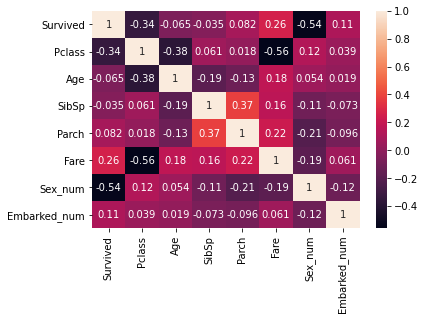

In [93]:
sns.heatmap(data.drop(columns=['PassengerId','Sex','Embarked','source']).corr(),annot=True)

<AxesSubplot:>

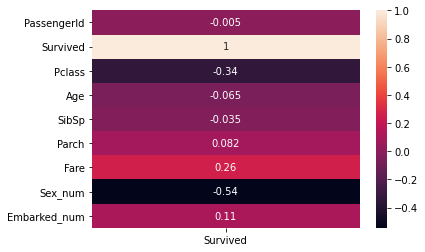

In [94]:
sns.heatmap(data.corr()[['Survived']],annot=True)

In [95]:
combinfo(data).T

PassengerId Survived   Pclass      Sex      Age    SibSp  \
Nunique()             1309        2        3        2       98        7   
isna() count             0      418        0        0        0        0   
Non-Null count        1309      891     1309     1309     1309     1309   
Dtype              int64    float64  int64    object   float64  int64     

                  Parch     Fare Embarked   source  Sex_num Embarked_num  
Nunique()             8      281        3        2        2            3  
isna() count          0        0        0        0        0            0  
Non-Null count     1309     1309     1309     1309     1309         1309  
Dtype           int64    float64  object   object   int64        float64

In [96]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
       'Fare', 'Embarked', 'source', 'Sex_num', 'Embarked_num'],
      dtype='object')

In [97]:
data_preprocessed = data.drop(columns=["Sex","Embarked_num"])
data_preprocessed.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'source', 'Sex_num'],
      dtype='object')

In [98]:
data_preprocessed.head()

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare Embarked source  \
0            1       0.0       3  22.0      1      0   7.2500        S  train   
1            2       1.0       1  38.0      1      0  71.2833        C  train   
2            3       1.0       3  26.0      0      0   7.9250        S  train   
3            4       1.0       1  35.0      1      0  53.1000        S  train   
4            5       0.0       3  35.0      0      0   8.0500        S  train   

   Sex_num  
0        1  
1        0  
2        0  
3        0  
4        1

In [99]:
data_preprocessed.shape, data_preprocessed.index

((1309, 10), RangeIndex(start=0, stop=1309, step=1))

In [100]:
combinfo(data_preprocessed)

Nunique()  isna() count Non-Null count    Dtype
PassengerId       1309             0           1309  int64  
Survived             2           418            891  float64
Pclass               3             0           1309  int64  
Age                 98             0           1309  float64
SibSp                7             0           1309  int64  
Parch                8             0           1309  int64  
Fare               281             0           1309  float64
Embarked             3             0           1309  object 
source               2             0           1309  object 
Sex_num              2             0           1309  int64

In [101]:
data_preprocessed["Pclass"] = data_preprocessed["Pclass"].astype('O')
data_preprocessed["SibSp"] = data_preprocessed["SibSp"].astype('O')
data_preprocessed["Parch"] = data_preprocessed["Parch"].astype('O')
print(combinfo(data_preprocessed))
num_col = data_preprocessed.select_dtypes(include=np.number).drop(columns =['PassengerId','Survived','Sex_num']).columns
cat_col = data_preprocessed.select_dtypes(exclude=np.number).drop(columns ='source').columns
num_col, cat_col

             Nunique()  isna() count Non-Null count    Dtype
PassengerId       1309             0           1309  int64  
Survived             2           418            891  float64
Pclass               3             0           1309  object 
Age                 98             0           1309  float64
SibSp                7             0           1309  object 
Parch                8             0           1309  object 
Fare               281             0           1309  float64
Embarked             3             0           1309  object 
source               2             0           1309  object 
Sex_num              2             0           1309  int64  


(Index(['Age', 'Fare'], dtype='object'),
 Index(['Pclass', 'SibSp', 'Parch', 'Embarked'], dtype='object'))

In [102]:
cat_col_transform = pd.get_dummies(data_preprocessed[cat_col])
cat_col_transform

Pclass_1  Pclass_2  Pclass_3  SibSp_0  SibSp_1  SibSp_2  SibSp_3  \
0            0         0         1        0        1        0        0   
1            1         0         0        0        1        0        0   
2            0         0         1        1        0        0        0   
3            1         0         0        0        1        0        0   
4            0         0         1        1        0        0        0   
...        ...       ...       ...      ...      ...      ...      ...   
1304         0         0         1        1        0        0        0   
1305         1         0         0        1        0        0        0   
1306         0         0         1        1        0        0        0   
1307         0         0         1        1        0        0        0   
1308         0         0         1        0        1        0        0   

      SibSp_4  SibSp_5  SibSp_8  ...  Parch_1  Parch_2  Parch_3  Parch_4  \
0           0        0        0  ...        0        0        0        0   
1           0        0        0  ...        0        0        0        0   
2           0        0        0  ...        0        0        0        0   
3           0        0        0  ...        0        0        0        0   
4           0        0        0  ...        0        0        0        0   
...       ...      ...      ...  ...      ...      ...      ...      ...   
1304        0        0        0  ...        0        0        0        0   
1305        0        0        0  ...        0        0        0        0   
1306        0        0        0  ...        0        0        0        0   
1307        0        0        0  ...        0        0        0        0   
1308        0        0        0  ...        1        0        0        0   

      Parch_5  Parch_6  Parch_9  Embarked_C  Embarked_Q  Embarked_S  
0           0        0        0           0           0           1  
1           0        0        0           1           0           0  
2           0        0        0           0           0           1  
3           0        0        0           0           0           1  
4           0        0        0           0           0           1  
...       ...      ...      ...         ...         ...         ...  
1304        0        0        0           0           0           1  
1305        0        0        0           1           0           0  
1306        0        0        0           0           0           1  
1307        0        0        0           0           0           1  
1308        0        0        0           1           0           0  

[1309 rows x 21 columns]

In [103]:
scaler = MinMaxScaler()
num_col_transform = pd.DataFrame(scaler.fit_transform(data_preprocessed[num_col]), columns=num_col)
num_col_transform

Age      Fare
0     0.273456  0.014151
1     0.473882  0.139136
2     0.323563  0.015469
3     0.436302  0.103644
4     0.436302  0.015713
...        ...       ...
1304  0.348616  0.015713
1305  0.486409  0.212559
1306  0.480145  0.014151
1307  0.348616  0.015713
1308  0.348616  0.043640

[1309 rows x 2 columns]

In [106]:
print(data_preprocessed['PassengerId'].shape,cat_col_transform.shape, num_col_transform.shape)
print(data_preprocessed['PassengerId'].index,cat_col_transform.index, num_col_transform.index)
print(data_preprocessed.columns,cat_col_transform.columns, num_col_transform.columns)

(1309,) (1309, 21) (1309, 2)
RangeIndex(start=0, stop=1309, step=1) RangeIndex(start=0, stop=1309, step=1) RangeIndex(start=0, stop=1309, step=1)
Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'source', 'Sex_num'],
      dtype='object') Index(['Pclass_1', 'Pclass_2', 'Pclass_3', 'SibSp_0', 'SibSp_1', 'SibSp_2',
       'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1',
       'Parch_2', 'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9',
       'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object') Index(['Age', 'Fare'], dtype='object')


In [108]:
data_preprocessed_cat_num = pd.concat([data_preprocessed[['PassengerId','Survived','source', 'Sex_num']],cat_col_transform, num_col_transform], axis = 1)
data_preprocessed_cat_num

PassengerId  Survived source  Sex_num  Pclass_1  Pclass_2  Pclass_3  \
0               1       0.0  train        1         0         0         1   
1               2       1.0  train        0         1         0         0   
2               3       1.0  train        0         0         0         1   
3               4       1.0  train        0         1         0         0   
4               5       0.0  train        1         0         0         1   
...           ...       ...    ...      ...       ...       ...       ...   
1304         1305       NaN   test        1         0         0         1   
1305         1306       NaN   test        0         1         0         0   
1306         1307       NaN   test        1         0         0         1   
1307         1308       NaN   test        1         0         0         1   
1308         1309       NaN   test        1         0         0         1   

      SibSp_0  SibSp_1  SibSp_2  ...  Parch_3  Parch_4  Parch_5  Parch_6  \
0           0        1        0  ...        0        0        0        0   
1           0        1        0  ...        0        0        0        0   
2           1        0        0  ...        0        0        0        0   
3           0        1        0  ...        0        0        0        0   
4           1        0        0  ...        0        0        0        0   
...       ...      ...      ...  ...      ...      ...      ...      ...   
1304        1        0        0  ...        0        0        0        0   
1305        1        0        0  ...        0        0        0        0   
1306        1        0        0  ...        0        0        0        0   
1307        1        0        0  ...        0        0        0        0   
1308        0        1        0  ...        0        0        0        0   

      Parch_9  Embarked_C  Embarked_Q  Embarked_S       Age      Fare  
0           0           0           0           1  0.273456  0.014151  
1           0           1           0           0  0.473882  0.139136  
2           0           0           0           1  0.323563  0.015469  
3           0           0           0           1  0.436302  0.103644  
4           0           0           0           1  0.436302  0.015713  
...       ...         ...         ...         ...       ...       ...  
1304        0           0           0           1  0.348616  0.015713  
1305        0           1           0           0  0.486409  0.212559  
1306        0           0           0           1  0.480145  0.014151  
1307        0           0           0           1  0.348616  0.015713  
1308        0           1           0           0  0.348616  0.043640  

[1309 rows x 27 columns]

In [109]:
combinfo(data_preprocessed_cat_num)

Nunique()  isna() count Non-Null count    Dtype
PassengerId       1309             0           1309  int64  
Survived             2           418            891  float64
source               2             0           1309  object 
Sex_num              2             0           1309  int64  
Pclass_1             2             0           1309  uint8  
Pclass_2             2             0           1309  uint8  
Pclass_3             2             0           1309  uint8  
SibSp_0              2             0           1309  uint8  
SibSp_1              2             0           1309  uint8  
SibSp_2              2             0           1309  uint8  
SibSp_3              2             0           1309  uint8  
SibSp_4              2             0           1309  uint8  
SibSp_5              2             0           1309  uint8  
SibSp_8              2             0           1309  uint8  
Parch_0              2             0           1309  uint8  
Parch_1              2             0           1309  uint8  
Parch_2              2             0           1309  uint8  
Parch_3              2             0           1309  uint8  
Parch_4              2             0           1309  uint8  
Parch_5              2             0           1309  uint8  
Parch_6              2             0           1309  uint8  
Parch_9              2             0           1309  uint8  
Embarked_C           2             0           1309  uint8  
Embarked_Q           2             0           1309  uint8  
Embarked_S           2             0           1309  uint8  
Age                 98             0           1309  float64
Fare               281             0           1309  float64

In [110]:
train_preprocessed = data_preprocessed_cat_num.query("source=='train'").drop(columns='source')
test_preprocessed = data_preprocessed_cat_num.query("source=='test'").drop(columns=['source','Survived'])

train_preprocessed.shape, test_preprocessed.shape, train_preprocessed.index, test_preprocessed.index
display(train_preprocessed)
display(test_preprocessed)
train_preprocessed.to_csv("train_preprocessed_basic.csv", index = False)
test_preprocessed.to_csv("test_preprocessed_basic.csv", index = False)

PassengerId  Survived  Sex_num  Pclass_1  Pclass_2  Pclass_3  SibSp_0  \
0              1       0.0        1         0         0         1        0   
1              2       1.0        0         1         0         0        0   
2              3       1.0        0         0         0         1        1   
3              4       1.0        0         1         0         0        0   
4              5       0.0        1         0         0         1        1   
..           ...       ...      ...       ...       ...       ...      ...   
886          887       0.0        1         0         1         0        1   
887          888       1.0        0         1         0         0        1   
888          889       0.0        0         0         0         1        0   
889          890       1.0        1         1         0         0        1   
890          891       0.0        1         0         0         1        1   

     SibSp_1  SibSp_2  SibSp_3  ...  Parch_3  Parch_4  Parch_5  Parch_6  \
0          1        0        0  ...        0        0        0        0   
1          1        0        0  ...        0        0        0        0   
2          0        0        0  ...        0        0        0        0   
3          1        0        0  ...        0        0        0        0   
4          0        0        0  ...        0        0        0        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
886        0        0        0  ...        0        0        0        0   
887        0        0        0  ...        0        0        0        0   
888        1        0        0  ...        0        0        0        0   
889        0        0        0  ...        0        0        0        0   
890        0        0        0  ...        0        0        0        0   

     Parch_9  Embarked_C  Embarked_Q  Embarked_S       Age      Fare  
0          0           0           0           1  0.273456  0.014151  
1          0           1           0           0  0.473882  0.139136  
2          0           0           0           1  0.323563  0.015469  
3          0           0           0           1  0.436302  0.103644  
4          0           0           0           1  0.436302  0.015713  
..       ...         ...         ...         ...       ...       ...  
886        0           0           0           1  0.336089  0.025374  
887        0           0           0           1  0.235876  0.058556  
888        0           0           0           1  0.348616  0.045771  
889        0           1           0           0  0.323563  0.058556  
890        0           0           1           0  0.398722  0.015127  

[891 rows x 26 columns]

PassengerId  Sex_num  Pclass_1  Pclass_2  Pclass_3  SibSp_0  SibSp_1  \
891           892        1         0         0         1        1        0   
892           893        0         0         0         1        0        1   
893           894        1         0         1         0        1        0   
894           895        1         0         0         1        1        0   
895           896        0         0         0         1        0        1   
...           ...      ...       ...       ...       ...      ...      ...   
1304         1305        1         0         0         1        1        0   
1305         1306        0         1         0         0        1        0   
1306         1307        1         0         0         1        1        0   
1307         1308        1         0         0         1        1        0   
1308         1309        1         0         0         1        0        1   

      SibSp_2  SibSp_3  SibSp_4  ...  Parch_3  Parch_4  Parch_5  Parch_6  \
891         0        0        0  ...        0        0        0        0   
892         0        0        0  ...        0        0        0        0   
893         0        0        0  ...        0        0        0        0   
894         0        0        0  ...        0        0        0        0   
895         0        0        0  ...        0        0        0        0   
...       ...      ...      ...  ...      ...      ...      ...      ...   
1304        0        0        0  ...        0        0        0        0   
1305        0        0        0  ...        0        0        0        0   
1306        0        0        0  ...        0        0        0        0   
1307        0        0        0  ...        0        0        0        0   
1308        0        0        0  ...        0        0        0        0   

      Parch_9  Embarked_C  Embarked_Q  Embarked_S       Age      Fare  
891         0           0           1           0  0.430039  0.015282  
892         0           0           0           1  0.586622  0.013663  
893         0           0           1           0  0.774521  0.018909  
894         0           0           0           1  0.336089  0.016908  
895         0           0           0           1  0.273456  0.023984  
...       ...         ...         ...         ...       ...       ...  
1304        0           0           0           1  0.348616  0.015713  
1305        0           1           0           0  0.486409  0.212559  
1306        0           0           0           1  0.480145  0.014151  
1307        0           0           0           1  0.348616  0.015713  
1308        0           1           0           0  0.348616  0.043640  

[418 rows x 25 columns]

In [111]:
def print_score(y_act,y_pred,label) :
    print(label, "Accuracy score  :", accuracy_score(y_act,y_pred))
    print(label, "Recall score    :", recall_score(y_act,y_pred))
    print(label, "Precision score :", precision_score(y_act,y_pred))
    print(label, "F1 score        :", f1_score(y_act,y_pred))
    print(label, "ROC_AUC score   :", roc_auc_score(y_act,y_pred))
    print(label, "Confusion Matrix:\n", confusion_matrix(y_act,y_pred))
    print(label, "Classification Report\n", classification_report(y_act,y_pred))    
#print_score(y,y_train_pred,"Train")

In [112]:
def build_model(model,X,y,label):
    #model = LogisticRegression()
    model.fit(X,y)
    y_train_pred = model.predict(X)
    pd.Series(data=model.coef_[0],index=X.columns).plot(kind='bar')
    print_score(y,y_train_pred,label)

Train Accuracy score  : 0.8047138047138047
Train Recall score    : 0.6988304093567251
Train Precision score : 0.7709677419354839
Train F1 score        : 0.7331288343558282
Train ROC_AUC score   : 0.7847521809989454
Train Confusion Matrix:
 [[478  71]
 [103 239]]
Train Classification Report
               precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       549
         1.0       0.77      0.70      0.73       342

    accuracy                           0.80       891
   macro avg       0.80      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891

0    260
1    158
Name: Survived, dtype: int64


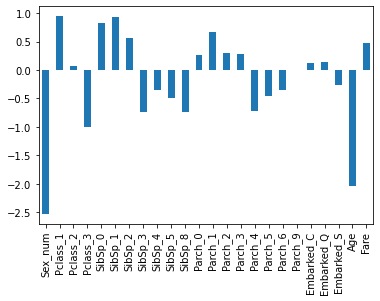

In [113]:
#with basic
X = train_preprocessed.drop(columns=["PassengerId","Survived"])
y = train_preprocessed["Survived"]
model = LogisticRegression()#(random_state=0, class_weight='balanced')
build_model(model,X,y,"Train")
test_X = test_preprocessed.drop(columns='PassengerId')
y_test_pred = model.predict(test_X).astype(int)
submission['Survived'] = y_test_pred
#submission['Survived'].replace({1:"Y",0:"N"}, inplace = True)
print(submission['Survived'].value_counts())
#submission.to_csv("Loan_logistic_base v1.csv",index = False)
#submisson 0.77033 -R65918

Train Accuracy score  : 0.813692480359147
Train Recall score    : 0.716374269005848
Train Precision score : 0.7802547770700637
Train F1 score        : 0.7469512195121951
Train ROC_AUC score   : 0.7953456044482792
Train Confusion Matrix:
 [[480  69]
 [ 97 245]]
Train Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       549
         1.0       0.78      0.72      0.75       342

    accuracy                           0.81       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891

0    256
1    162
Name: Survived, dtype: int64


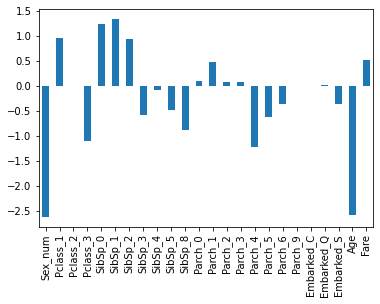

In [117]:
#with basic L2,L1,Elasticnet
X = train_preprocessed.drop(columns=["PassengerId","Survived"])
y = train_preprocessed["Survived"]
model = LogisticRegression(penalty='elasticnet', l1_ratio=0.6, C=2, solver='saga')#, random_state=0, class_weight='balanced')
build_model(model,X,y,"Train")
test_X = test_preprocessed.drop(columns='PassengerId')
y_test_pred = model.predict(test_X).astype(int)
submission['Survived'] = y_test_pred
print(submission['Survived'].value_counts())
#submission.to_csv("Loan_logistic_base_elastic v1.csv",index = False)
#0.77511
#0    256
#1    162

Train Accuracy score  : 0.8148148148148148
Train Recall score    : 0.7192982456140351
Train Precision score : 0.780952380952381
Train F1 score        : 0.7488584474885845
Train ROC_AUC score   : 0.7968075927523728
Train Confusion Matrix:
 [[480  69]
 [ 96 246]]
Train Classification Report
               precision    recall  f1-score   support

         0.0       0.83      0.87      0.85       549
         1.0       0.78      0.72      0.75       342

    accuracy                           0.81       891
   macro avg       0.81      0.80      0.80       891
weighted avg       0.81      0.81      0.81       891

0    260
1    158
Name: Survived, dtype: int64


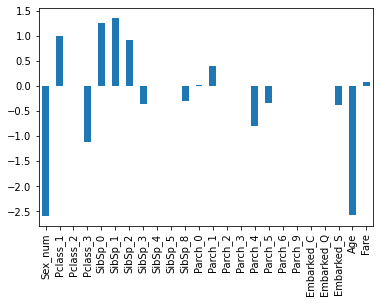

In [138]:
#using class_wt_bal (not effective)
X = train_preprocessed.drop(columns=["PassengerId","Survived"])
y = train_preprocessed["Survived"]
#model = LogisticRegression(random_state=0, class_weight='balanced') #lb-.75119
#model = LogisticRegression(penalty='elasticnet', l1_ratio=0.1, C=2, solver='saga')#,prec.774 
model = LogisticRegression(penalty='elasticnet', l1_ratio=0.9, C=1.3, solver='saga')#,prec.780 
build_model(model,X,y,"Train")
test_X = test_preprocessed.drop(columns='PassengerId')
y_test_pred = model.predict(test_X).astype(int)
submission['Survived'] = y_test_pred
print(submission['Survived'].value_counts())
submission.to_csv("Loan_logistic_base_elastic_l1r.9c1.3 v1.csv",index = False)
# 0.75119
#0    232
#1    186


In [139]:
submission.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1

In [136]:
sc=[50, 10, 5,3, 2, 1.3, 1, 0.1, 0.01, 0.05, 0.005]
st=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for it in sc:
    for jt in st:
        model = LogisticRegression(penalty='elasticnet', l1_ratio=jt, C=it, solver='saga')#, random_state=0, class_weight='balanced')
    #    model = LogisticRegression(penalty='l1', C=it, solver='liblinear', random_state=0, class_weight='balanced')
        model.fit(X,y)
        print("Score :", model.score(X,y),jt,it)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8103254769921436 0.1 50
Score : 0.8103254769921436 0.2 50
Score : 0.8103254769921436 0.3 50


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8103254769921436 0.4 50
Score : 0.8103254769921436 0.5 50
Score : 0.8103254769921436 0.6 50


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8103254769921436 0.7 50
Score : 0.8103254769921436 0.8 50
Score : 0.8103254769921436 0.9 50


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8103254769921436 1.0 50
Score : 0.8114478114478114 0.1 10
Score : 0.8114478114478114 0.2 10


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8114478114478114 0.3 10
Score : 0.8114478114478114 0.4 10
Score : 0.8114478114478114 0.5 10


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8114478114478114 0.6 10
Score : 0.8114478114478114 0.7 10
Score : 0.8114478114478114 0.8 10


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8114478114478114 0.9 10
Score : 0.8114478114478114 1.0 10
Score : 0.8125701459034792 0.1 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8114478114478114 0.2 5
Score : 0.8125701459034792 0.3 5
Score : 0.8125701459034792 0.4 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8125701459034792 0.5 5
Score : 0.8125701459034792 0.6 5
Score : 0.8125701459034792 0.7 5


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8125701459034792 0.8 5
Score : 0.8125701459034792 0.9 5
Score : 0.8125701459034792 1.0 5
Score : 0.8114478114478114 0.1 3
Score : 0.8125701459034792 0.2 3
Score : 0.8125701459034792 0.3 3
Score : 0.8125701459034792 0.4 3
Score : 0.8125701459034792 0.5 3
Score : 0.8125701459034792 0.6 3


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.8125701459034792 0.7 3
Score : 0.8125701459034792 0.8 3
Score : 0.8125701459034792 0.9 3


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Score : 0.813692480359147 1.0 3
Score : 0.8103254769921436 0.1 2
Score : 0.8114478114478114 0.2 2
Score : 0.8114478114478114 0.3 2
Score : 0.8114478114478114 0.4 2
Score : 0.813692480359147 0.5 2
Score : 0.813692480359147 0.6 2
Score : 0.813692480359147 0.7 2
Score : 0.813692480359147 0.8 2
Score : 0.813692480359147 0.9 2
Score : 0.8148148148148148 1.0 2
Score : 0.8069584736251403 0.1 1.3
Score : 0.8069584736251403 0.2 1.3
Score : 0.8092031425364759 0.3 1.3
Score : 0.8092031425364759 0.4 1.3
Score : 0.8092031425364759 0.5 1.3
Score : 0.8125701459034792 0.6 1.3
Score : 0.813692480359147 0.7 1.3
Score : 0.813692480359147 0.8 1.3
Score : 0.8148148148148148 0.9 1.3
Score : 0.813692480359147 1.0 1.3
Score : 0.8047138047138047 0.1 1
Score : 0.8047138047138047 0.2 1
Score : 0.8047138047138047 0.3 1
Score : 0.8080808080808081 0.4 1
Score : 0.8080808080808081 0.5 1
Score : 0.8092031425364759 0.6 1
Score : 0.8114478114478114 0.7 1
Score : 0.8092031425364759 0.8 1
Score : 0.8114478114478114 0.9 1